In [7]:
# Import all the necessary libraries.
import numpy as np
import timeit
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [8]:
# Reset pseudo random generator to a known value so that results are reproducible.
seed = 42
np.random.seed(seed)

### Função objetivo

$$y = 0.5 x^2 + x + 2$$

In [9]:
def true_func(N):
    x = np.sort(6*np.random.rand(N) - 3).reshape(N, 1)
    # Second order polynomial.
    y = 0.5*x**2 + x + 2
    # Noise.
    w = np.random.randn(N, 1)
    y_noisy = y + w 
    return x, y, y_noisy

### Gerando o dataset

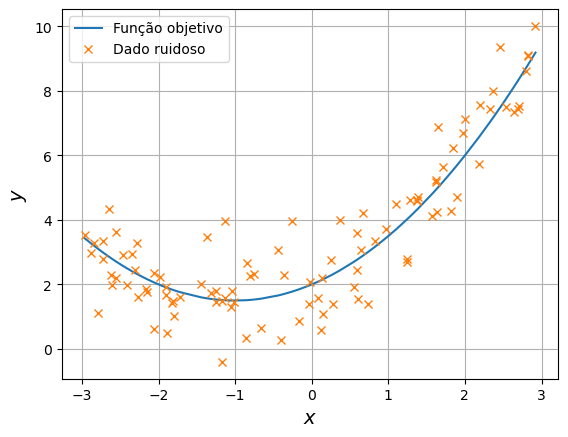

In [10]:
# Example set size.
N = 100

# Generate the dataset.
x, y, y_noisy = true_func(N)

# Plot original data versus noisy version.
fig = plt.figure()
plt.plot(x, y, label='Função objetivo')
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
# Save figure
#plt.savefig("noisy_function.png", dpi=600)
#Show the plot.
plt.show()

### Treinamento

+ Iteramos através de diferentes tamanhos máximos para o conjunto de treinamento e ordens do polinômio.


+ Para cada valor máximo do conjunto de treinamento e ordem do polinômio: 

    + Variamos o tamanho do conjunto até o valor máximo. 
    + Para cada novo tamanho do conjunto, embaralhamos o conjunto usando 100 sementes diferentes.
    + Calculamos o MSE para cada novo conjunto embaralhado e ao final, calculamos a média do MSE para todas as sementes.

In [5]:
# Polinomial degrees to be tested.
degrees = [1, 2, 20]   

# Validation set size.
testSize = [0.1, 0.2, 0.3, 0.4]

# Number of different seeds.
numOfSeeds = 100

mse_training = np.zeros((len(testSize), len(degrees), int(N*(1.0 - 0.1))+1 ))
mse_validation = np.zeros((len(testSize), len(degrees), int(N*(1.0 - 0.1))+1 ))

# Iterate over test sizes.
for t in range(0, len(testSize)):
    
    # Maximum number of training samples.
    trainSize = int(N*(1.0 - testSize[t]))

    # Iterate over the degrees.
    for i in range(0, len(degrees)):
        
        # Instantiate a polynomial.
        poly = PolynomialFeatures(degree=degrees[i])
        # Instantiate a scaler.
        scaler = StandardScaler()
        # Instantiate a linear regressor.
        reg = LinearRegression()

        # Create a pipeline of actions.
        poly_reg = Pipeline([
            ("poly", poly),
            ("scaler", scaler),
            ("reg", reg),
        ])
        
        # Iterate over the size of the training set.
        for m in range(1, trainSize+1):                
                
            # Use several different seeds.
            for s in range(0, numOfSeeds):     

                # Split the whole set into random training and validation set.
                x_train, x_val, y_train, y_val = train_test_split(x, y_noisy, test_size=testSize[t], random_state=s)

                # Perform polynomial regression.
                poly_reg.fit(x_train[:m], y_train[:m])

                # Use the trained model for prediction of the training set.
                y_train_predict = poly_reg.predict(x_train[:m])

                # Use the trained model for prediction of the validation set.
                y_val_predict = poly_reg.predict(x_val)       

                # Calculate MSE for training set.
                mse_training[t, i, m-1] += mean_squared_error(y_train[:m], y_train_predict)

                # Calculate MSE for validation set.
                mse_validation[t, i, m-1] += mean_squared_error(y_val, y_val_predict)
            
            mse_training[t, i, m-1] /= numOfSeeds
            mse_validation[t, i, m-1] /= numOfSeeds

### Resultados

#### Polinômio de ordem 1.

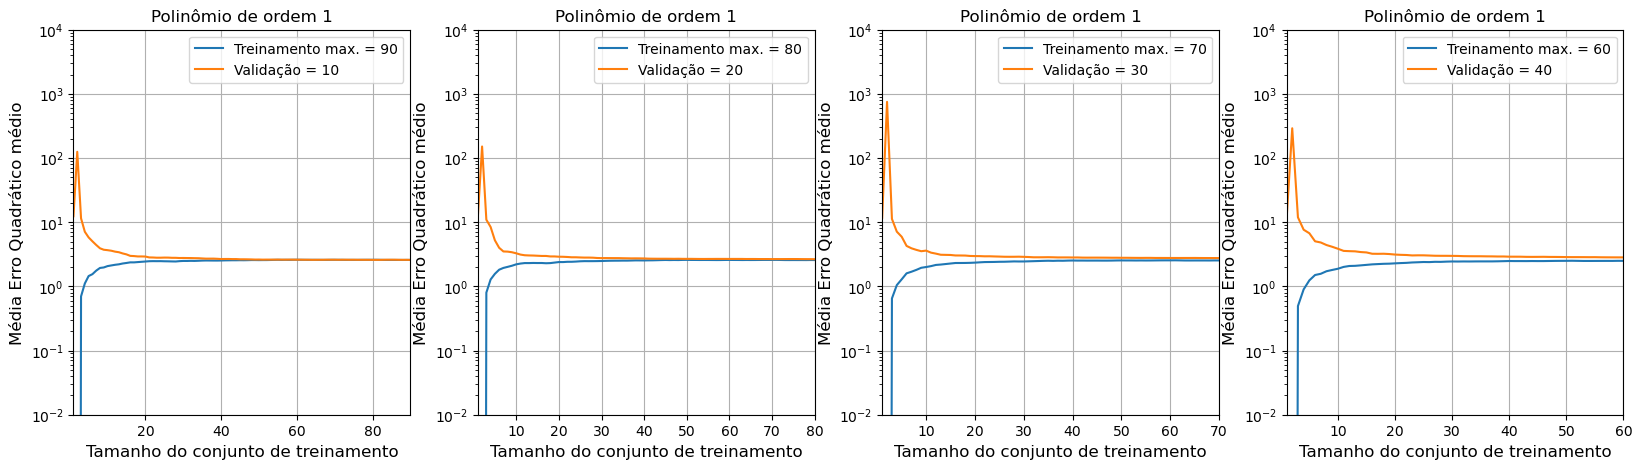

In [42]:
# Polinômio de ordem 1.
i = 0

plt.figure(figsize=(20, 5))
for t in range(0,len(testSize)):
    
    trainSize = int(N*(1.0 - testSize[t]))
        
    ax = plt.subplot(1, 4, t + 1)
    
    ax.plot(range(1, trainSize+1), mse_training[t, i, 0:trainSize], label='Treinamento max. = '+str(trainSize))
    ax.plot(range(1, trainSize+1), mse_validation[t, i, 0:trainSize], label='Validação = '+str(N-trainSize))
    ax.set_yscale('log')
    ax.set_xlabel('Tamanho do conjunto de treinamento', fontsize=12)
    ax.set_ylabel('Média Erro Quadrático médio', fontsize=12)
    ax.grid()
    ax.set_ylim([1e-2, 1e4])
    ax.set_xlim([1, trainSize])
    ax.set_title('Polinômio de ordem '+str(degrees[i]))
    ax.legend(loc='best')
    
# Show the plot.
plt.show()

+ **Com 1 ou 2 exemplos no conjunto de treinamento, o modelo se ajusta perfeitamente (reta)**. Porém, conforme o número de exemplos aumenta, é impossível para ele se ajustar (os dados não têm mapeamento lineares e as amostras estão corrompidas com ruído).


+ O **erro de treinamento aumenta até atingir um platô e não diminui**, mesmo com o aumento do conjunto de treinamento, pois o modelo não tem flexibilidade.


+ O **erro de validação é alto quando o modelo é treinado com poucos exemplos** (1 ou 2, pois ocorre sobreajuste). Porém, ele diminui conforme o conjunto de treinamento aumenta, terminando em um platô próximo do erro de treinamento (subajuste).


+ Essas **curvas são típicas de um modelo que está subajustando** (erros altos e próximos).


+ O que devemos fazer? 
    + Aumentar a ordem do modelo.

#### Polinômio de ordem 20

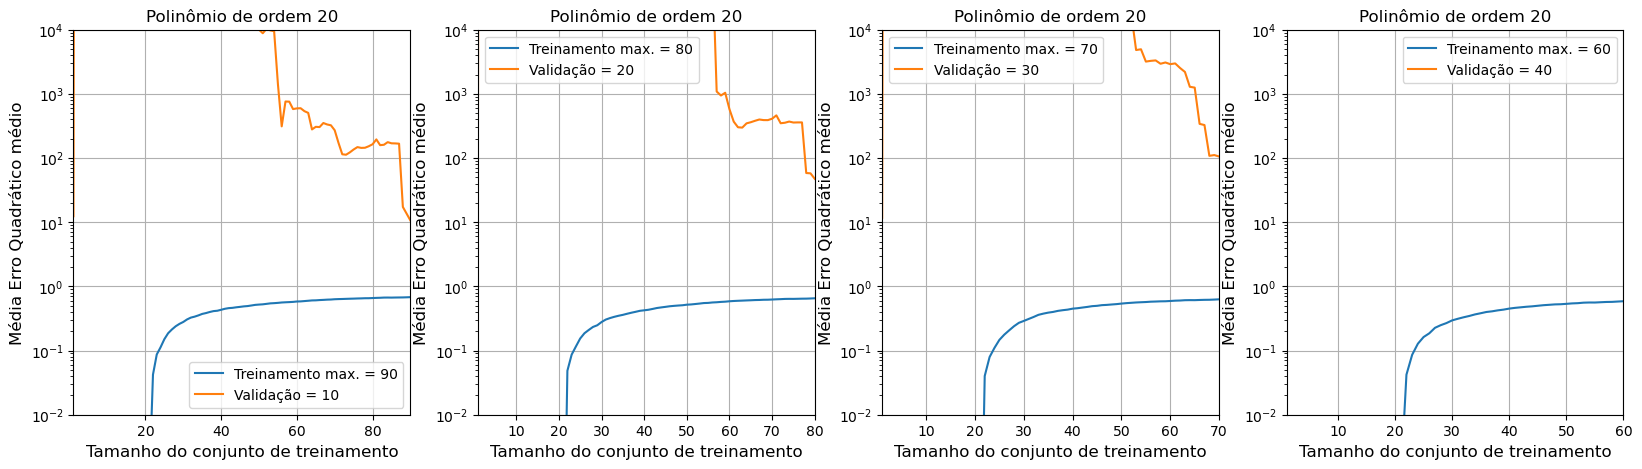

In [43]:
# Polinômio de ordem 2.
i = 2

plt.figure(figsize=(20, 5))
for t in range(0,len(testSize)):
    
    trainSize = int(N*(1.0 - testSize[t]))
        
    ax = plt.subplot(1, 4, t + 1)
    
    ax.plot(range(1, trainSize+1), mse_training[t, i, 0:trainSize], label='Treinamento max. = '+str(trainSize))
    ax.plot(range(1, trainSize+1), mse_validation[t, i, 0:trainSize], label='Validação = '+str(N-trainSize))
    ax.set_yscale('log')
    ax.set_xlabel('Tamanho do conjunto de treinamento', fontsize=12)
    ax.set_ylabel('Média Erro Quadrático médio', fontsize=12)
    ax.grid()
    ax.set_ylim([1e-2, 1e4])
    ax.set_xlim([1, trainSize])
    ax.set_title('Polinômio de ordem '+str(degrees[i]))
    ax.legend(loc='best')
    
# Show the plot.
plt.show()

+ No geral, o **erro de treinamento é menor do que com o modelo de ordem 1**.


+ Até um conjunto de treinamento com pouco mais de 20 exemplos, o erro de treinamento é muito pequeno e o de validação muito alto, indicando sobreajuste.


+ Existe uma **diferença considerável entre as curvas do erro de treinamento e de validação**. 


+ Isso significa que o **modelo tem um desempenho melhor no conjunto de treinamento do que no conjunto de validação**, indicando que ele está **sobreajustando**.


+ A **performance do modelo melhora caso o conjunto de treinamento aumente**.


+ Com um conjunto de treinamento maior, a tendência é que ambos os erros convirjam para o MSE mínimo.
    + Exemplo: [curvas_de_aprendizado_dataset_maior.ipynb](https://colab.research.google.com/github/zz4fap/tp555-ml/blob/main/exemplos/non-linear-regression/curvas_de_aprendizado_dataset_maior.ipynb)


+ O que fazer? 
    + Diminuir a ordem do modelo ou aumentar o conjunto de treinamento.

#### Polinômio de ordem 2

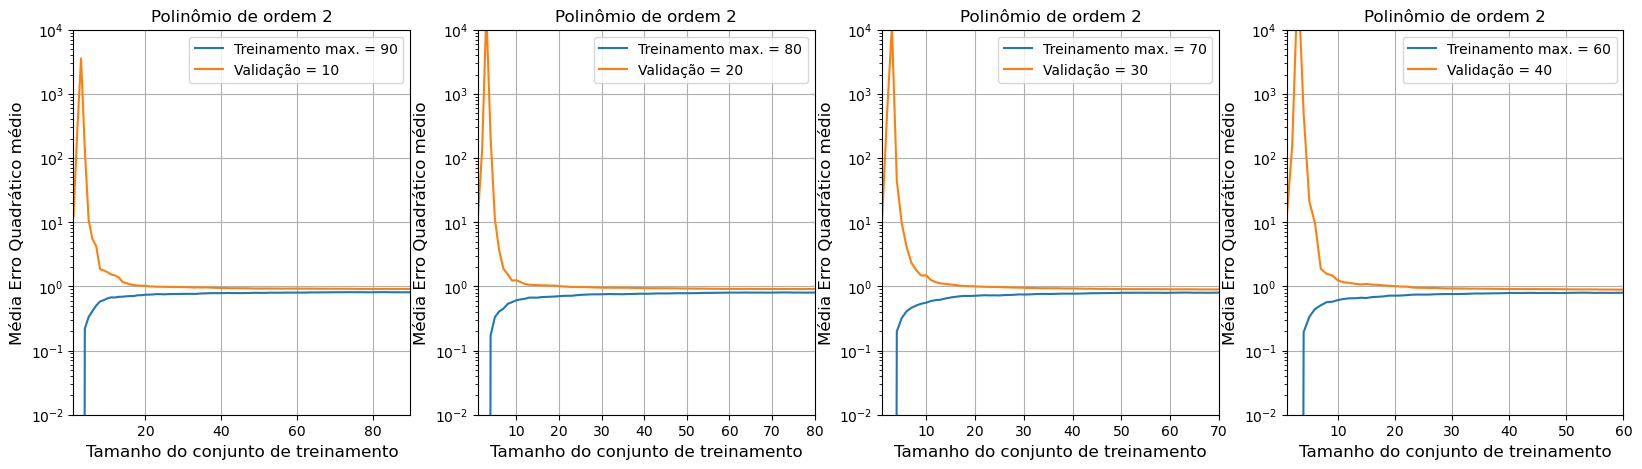

In [44]:
# Polinômio de ordem 2.
i = 1

plt.figure(figsize=(20, 5))
for t in range(0,len(testSize)):
    
    trainSize = int(N*(1.0 - testSize[t]))
        
    ax = plt.subplot(1, 4, t + 1)
    
    ax.plot(range(1, trainSize+1), mse_training[t, i, 0:trainSize], label='Treinamento max. = '+str(trainSize))
    ax.plot(range(1, trainSize+1), mse_validation[t, i, 0:trainSize], label='Validação = '+str(N-trainSize))
    ax.set_yscale('log')
    ax.set_xlabel('Tamanho do conjunto de treinamento', fontsize=12)
    ax.set_ylabel('Média Erro Quadrático médio', fontsize=12)
    ax.grid()
    ax.set_ylim([1e-2, 1e4])
    ax.set_xlim([1, trainSize])
    ax.set_title('Polinômio de ordem '+str(degrees[i]))
    ax.legend(loc='best')
    
# Show the plot.
plt.show()

+ A **diferença entre os erros diminui com o aumento do conjunto de treinamento**, se tornando pequena.


+ Ambos os **erros (i.e., treinamento e validação) são menores do que com o modelo de ordem 1** (i.e., reta).


+ Isso é a **indicação de um modelo que está se ajustando bem aos dados de treinamento** (i.e., flexibilidade) e é **capaz de generalizar bem para os dados de validação**.


+ Aumentar o conjunto de treinamento faz com que a diferença entre as duas curvas se torne ainda menor.


+ O que fazer? 
    + Escolher esta ordem de polinômio.